En este notebook se evaluan los modelos entrenados. Se carga el data set configurado, y se realiza la unificación de las clases 0-4 para el target. Luego, se realiza la transformación con el pipeline, se cargan los modelos, se scorea, y finalmente se muestran los resultados con una matriz de confusión y ciertos reportes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
from utils.eval import *
import joblib

In [3]:
from IPython.core.display import display, HTML
display(
   HTML("<style>.container { width:95% !important; }</style>"))
display(
   HTML("<style>.prompt { font-size: 10px !important; }</style>"))

## Config

In [4]:
cmap = plt.cm.Reds

In [5]:
data = 'train'

## Load data

In [6]:
data_path = "data/"
input_path = data_path + "input/"
models_path = data_path + "models/"
columns_path = data_path + "columns/"
pipelines_path = data_path + "pipelines/"

In [7]:
df = pd.read_csv(input_path + data + '.csv', sep='\t', encoding='utf-8', )  
df.head()

,installments.quantity,installments.rate,id,site_id,title,price,currency_id,available_quantity,sold_quantity,buying_mode,...,address.state_name,shipping.free_shipping,shipping.mode,shipping.logistic_type,shipping.store_pick_up,seller.seller_reputation.real_level,root_category_id,root_category_name,discount,category_name
0,12.0,70.17,MLA901604420,MLA,Hacha - Bendy And The Ink Machine - Prop,1800.00,ARS,50,25,buy_it_now,...,Buenos Aires,False,me2,xd_drop_off,False,NaN,MLA1132,Juegos y Juguetes,NaN,Muñecos y Figuras de Acción
1,12.0,70.17,MLA785203596,MLA,Microscopio Lupa Celular Tricomas 60x Led Gabb...,1199.00,ARS,1,500,buy_it_now,...,Buenos Aires,False,me2,cross_docking,False,NaN,MLA1039,Cámaras y Accesorios,NaN,Microscopios
2,12.0,70.17,MLA703379424,MLA,Chapa De Madera De Guatambú - Lamina Para Ench...,420.00,ARS,1,250,buy_it_now,...,Buenos Aires,False,me2,xd_drop_off,False,green,MLA1367,Antigüedades y Colecciones,NaN,Otros
3,12.0,70.17,MLA647580156,MLA,Bomba Electrica De Combustible Nafta O Gasoil ...,2426.00,ARS,500,250,buy_it_now,...,Buenos Aires,False,me2,cross_docking,False,NaN,MLA5725,Accesorios para Vehículos,NaN,Bombas de Combustible
4,12.0,70.17,MLA762063286,MLA,Juego X 4 Tazas Vw Gol / Gol Trend Rodado 14 P...,2439.99,ARS,1,500,buy_it_now,...,Buenos Aires,False,me2,fulfillment,False,NaN,MLA5725,Accesorios para Vehículos,NaN,Tazas


In [8]:
df.shape

(23180, 43)

## IDs

In [9]:
id_cols = joblib.load(columns_path + 'id_cols.joblib')
id_cols

['id',
 'site_id',
 'title',
 'category_id',
 'seller.id',
 'catalog_product_id',
 'root_category_id',
 'root_category_name',
 'category_name']

In [10]:
df_ID = df[id_cols].copy()
df = df.drop(id_cols, axis= 1)

## Distribución de valores para el target

In [11]:
df.sold_quantity.value_counts().sort_index()

0        2325
1         212
2         187
3         173
4         161
5        1740
25       1379
50       2105
100      1599
150      1291
200      1086
250      3541
500      6859
5000      514
50000       8
Name: sold_quantity, dtype: int64

<AxesSubplot:>

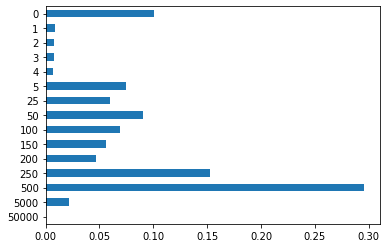

In [12]:
df.sold_quantity.value_counts(normalize=True).sort_index(ascending=False).plot.barh()

## Manipulación clases

In [13]:
df["sold_quantity"] = [x if x >= 5 else 1 for x in df["sold_quantity"]]

In [14]:
df.sold_quantity.value_counts().sort_index()

1        3058
5        1740
25       1379
50       2105
100      1599
150      1291
200      1086
250      3541
500      6859
5000      514
50000       8
Name: sold_quantity, dtype: int64

## Y

In [15]:
y = df.sold_quantity

In [16]:
df = df.drop(['sold_quantity'], axis= 1)

## Paths

In [17]:
cols_path = columns_path + "final_cols.joblib" 
pipeline_path = pipelines_path + "pipeline.joblib" 
models_path_template = models_path + '{}.joblib'

## Load objects

In [18]:
# pipeline
pipeline = joblib.load(pipeline_path)
# cols
cols = joblib.load(cols_path)  


## Transform df

In [19]:
df_copy = df.copy()
df_copy = pipeline.transform(df_copy)

## Load models and predict

In [20]:
models = [ 'xgb', 
           'mlp', 
           'lr' 
]

In [21]:
dict_res = {}
for k in models:
    dict_res[k] = {}
    # ----------------- load model -------------------
    model = get_model(k, models_path_template.format(k))
    # ----------------- get preds -------------------
    preds = model.predict(df_copy[cols])
    dict_res[k]['model'] = model
    dict_res[k]['preds'] = preds

## --------------------------- <p style='color:blue; font-weight:bold'> XGB </p> ---------------------------

In [22]:
dict_res['xgb']['model']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=7, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=1111, subsample=1,
              tree_method='auto', validate_parameters=1, verbosity=None)

In [23]:
predicted_classes = dict_res['xgb']['preds']

In [24]:
classes = np.unique(predicted_classes)
classes

array([    1,     5,    25,    50,   100,   150,   200,   250,   500,
        5000, 50000])

In [25]:
print_pred_classes_prop(predicted_classes)

Predicted classes proportions
--------------
1        0.127524
5        0.084254
25       0.049482
50       0.095988
100      0.053063
150      0.037575
200      0.025151
250      0.136928
500      0.371268
5000     0.018507
50000    0.000259
dtype: float64 



Confusion matrix, without normalization


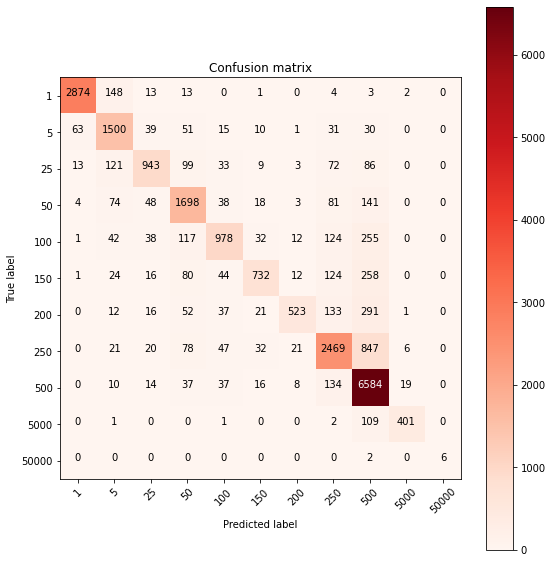

In [26]:
make_cmx(y, predicted_classes, classes, cmap=cmap)

In [27]:
make_classif_report(y, predicted_classes, classes)

,precision,recall,f1-score,support
1,0.97,0.94,0.96,3058.00
5,0.77,0.86,0.81,1740.00
25,0.82,0.68,0.75,1379.00
50,0.76,0.81,0.78,2105.00
100,0.80,0.61,0.69,1599.00
150,0.84,0.57,0.68,1291.00
200,0.90,0.48,0.63,1086.00
250,0.78,0.70,0.74,3541.00
500,0.77,0.96,0.85,6859.00
5000,0.93,0.78,0.85,514.00


## --------------------------- <p style='color:blue; font-weight:bold'> LR </p> ---------------------------

In [28]:
dict_res['lr']['model']

LogisticRegression(C=10, class_weight='balanced', multi_class='ovr',
                   random_state=1111, solver='saga')

In [29]:
predicted_classes = dict_res['lr']['preds']

In [30]:
classes = np.unique(predicted_classes)
classes

array([    1,     5,    25,    50,   100,   150,   200,   250,   500,
        5000, 50000], dtype=int64)

In [31]:
print_pred_classes_prop(predicted_classes)

Predicted classes proportions
--------------
1        0.106903
5        0.168248
25       0.032226
50       0.096290
100      0.058154
150      0.034771
200      0.101769
250      0.056471
500      0.244090
5000     0.085332
50000    0.015746
dtype: float64 



Confusion matrix, without normalization


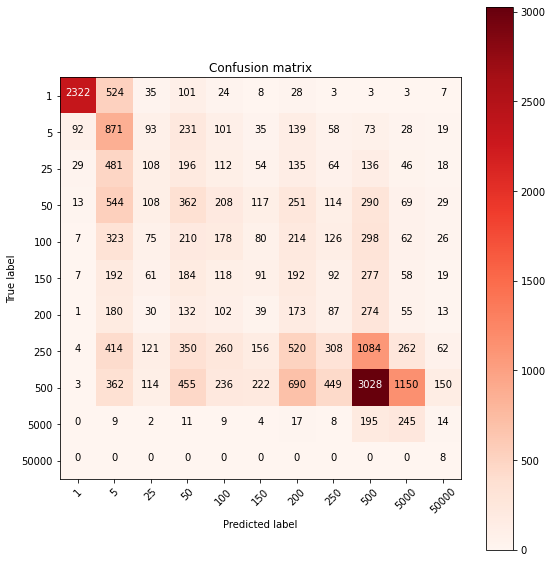

In [32]:
make_cmx(y, predicted_classes, classes, cmap=cmap)

In [33]:
make_classif_report(y, predicted_classes, classes)


,precision,recall,f1-score,support
1,0.94,0.76,0.84,3058.00
5,0.22,0.50,0.31,1740.00
25,0.14,0.08,0.10,1379.00
50,0.16,0.17,0.17,2105.00
100,0.13,0.11,0.12,1599.00
150,0.11,0.07,0.09,1291.00
200,0.07,0.16,0.10,1086.00
250,0.24,0.09,0.13,3541.00
500,0.54,0.44,0.48,6859.00
5000,0.12,0.48,0.20,514.00


## --------------------------- <p style='color:blue; font-weight:bold'> MLP </p> ---------------------------

In [34]:
dict_res['mlp']['model']

MLPClassifier(alpha=0.001, batch_size=64,
              hidden_layer_sizes=(64, 64, 64, 64, 64), learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=1800, random_state=1111,
              solver='sgd')

In [35]:
predicted_classes = dict_res['mlp']['preds']

In [36]:
classes = np.unique(predicted_classes)
classes

array([    1,     5,    25,    50,   100,   150,   200,   250,   500,
        5000, 50000], dtype=int64)

In [37]:
print_pred_classes_prop(predicted_classes)

Predicted classes proportions
--------------
1        0.123900
5        0.091070
25       0.053192
50       0.100992
100      0.066091
150      0.049482
200      0.038913
250      0.136195
500      0.321355
5000     0.018507
50000    0.000302
dtype: float64 



Confusion matrix, without normalization


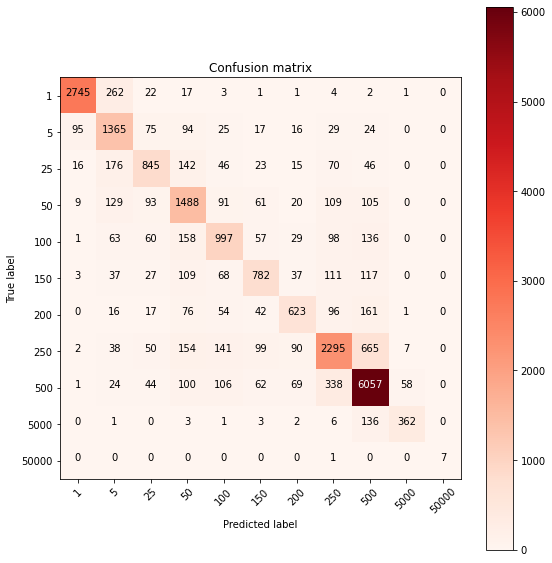

In [38]:
make_cmx(y, predicted_classes, classes, cmap=cmap)

In [39]:
make_classif_report(y, predicted_classes, classes)

,precision,recall,f1-score,support
1,0.96,0.90,0.93,3058.00
5,0.65,0.78,0.71,1740.00
25,0.69,0.61,0.65,1379.00
50,0.64,0.71,0.67,2105.00
100,0.65,0.62,0.64,1599.00
150,0.68,0.61,0.64,1291.00
200,0.69,0.57,0.63,1086.00
250,0.73,0.65,0.69,3541.00
500,0.81,0.88,0.85,6859.00
5000,0.84,0.70,0.77,514.00
